## Introduction/Business Problem 

* Assume you are a global investor in field of gastronomy and you are looking to open a chain of restaurants in biggest cities in Europe. Many cities... 

* Obviously you don not know every single city, and actually don't know where to locate your restaurants. Whether it's  good idea to invest only in city centers, or maybe most of restaurants are hidden in some specific districts.

* The aim of this analysis if to automatically find area of city with biggest density of restaurants and nightlife facilities using segmentation. I'll be profiling districts of Warsaw (capital city of Poland) as a small prof of concept because I know the city and can verify whether findings from segmentation looks reasonable or not. 


## Data

* Scraped list of postal codes in Warsaw: http://www.kody-pocztowe.dokladnie.com/ There are more than 4k of them, so I used sample of them
* After we get postal codes we can geocode them and get latitudes and longitutes for map visualisation
* Foursquare location data  - via Foursqare API we can obtain POI with categories, like restaurants, shops, parks etc..

In [1]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

import json 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium # map rendering library

# !pip install lxml
# !pip install html5lib 
import lxml
import html5lib

print('Libraries imported.')

Libraries imported.


## Scraping list of districts in Warsaw

In [2]:
tables = pd.read_html("http://www.kody-pocztowe.dokladnie.com/")

print(type(tables))
print(type(tables[1]))
print(tables[1].shape)
tables[1].iloc[0:5,]

<class 'list'>
<class 'pandas.core.frame.DataFrame'>
(7031, 5)


,0,1,2,3,4
0,KOD POCZTOWY,ADRES,MIEJSCOWOŚĆ,WOJEWÓDZTWO,POWIAT
1,00-001,"Poczta Warszawa 001, ul. Świętokrzyska 31/33",Warszawa,mazowieckie,M. Warszawa
2,00-001,ul. Świętokrzyska 31/33,Warszawa,mazowieckie,M. Warszawa
3,00-002,ul. Świętokrzyska od 20 do 22,Warszawa,mazowieckie,M. Warszawa
4,00-003,ul. Jasna od 9 do 17,Warszawa,mazowieckie,M. Warszawa


In [22]:
tables[1].iloc[0,].tolist()

['KOD POCZTOWY', 'ADRES', 'MIEJSCOWOŚĆ', 'WOJEWÓDZTWO', 'POWIAT']

In [3]:
df = tables[1].iloc[1:,]
df2 = df[df[2]=='Warszawa']
# print(df2.shape)
postal_codes = df2[0].unique().tolist()
print('number of unique postal codes in Warsaw city:',len(postal_codes))
postal_codes[-5:] # 5 last
# last: 05-077

number of unique postal codes in Warsaw city: 4195


['04-997', '04-998', '05-075', '05-076', '05-077']

In [4]:
postal_codes_tst=postal_codes[:2]+postal_codes[-2:]
postal_codes_tst

['00-001', '00-002', '05-076', '05-077']

## Foursquare Credentials and Version - TO CUT

In [5]:
CLIENT_ID     = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

## Geocoder

In [7]:
df3 = pd.DataFrame.from_items([('p_cod', postal_codes)])
df3['lat'] = np.nan
df3['lng'] = np.nan
print(len(df3))
df3.head()

4195


,p_cod,lat,lng
0,00-001,NaN,NaN
1,00-002,NaN,NaN
2,00-003,NaN,NaN
3,00-004,NaN,NaN
4,00-005,NaN,NaN


## Iteratively geocoding postal codes - about 1.2k per request/day(?) avaliable
-> "HTTPError: HTTP Error 429: Too Many Requests"

In [28]:
df_tmp = df3.iloc[2545:,]
print(df_tmp.shape)
# df_tmp.head()

(1650, 3)


In [255]:
for i in range(len(df_tmp)):
    adr = df_tmp.iloc[i,0] +' ,Warszawa, Polska'
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(adr)
    
    df_tmp.iloc[i,1] = float(location.latitude)
    df_tmp.iloc[i,2] = float(location.longitude)

print(len(df_tmp))

1650


In [257]:
# print(len(df_tmp))
# df_tmp.loc[2540:2550,]

In [30]:
# df4b = df_tmp.loc[:2544,]
# print(df4b.shape)
# df4b.head()
# df4b.iloc[-5:,]

## Saving request results to csv 

In [24]:
# pd.DataFrame.to_csv(df4, 'warsaw_postal_codes1_lat_lng.csv')
# pd.DataFrame.to_csv(df4b, 'warsaw_postal_codes2_lat_lng.csv')

In [31]:
w1 = pd.DataFrame.from_csv('warsaw_postal_codes1_lat_lng.csv')
w2 = pd.DataFrame.from_csv('warsaw_postal_codes2_lat_lng.csv')

In [35]:
w2.tail()

,p_cod,lat,lng
2540,03-001,52.343144,20.987334
2541,03-002,52.350856,21.022727
2542,03-003,52.342165,20.984265
2543,03-004,52.348557,20.993783
2544,03-005,52.231924,21.006727


## Sample some postal codes to speed up

In [61]:
df_w = pd.concat([w1.sample(n=100) ,
                  w2.sample(n=100) ]).drop_duplicates()
print(df_w.shape)
df_w.head()

(200, 3)


,p_cod,lat,lng
366,00-411,52.232867,21.040222
351,00-391,52.234831,21.033359
457,00-516,52.226938,21.015957
255,00-271,52.250156,21.010952
1094,01-302,52.217009,20.896087


In [62]:
map_ = folium.Map(location=[52.232810, 21.019067], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_w['lat'], df_w['lng'], df_w['p_cod']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_)  
    
map_

## Function to get all nearby venues

In [41]:

def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [64]:
LIMIT = 30
radius = 600
wawa_venues = getNearbyVenues(names=df_w['p_cod'],
                                   latitudes=df_w['lat'],
                                   longitudes=df_w['lng']
                                  )

00-411
00-391
00-516
00-271
01-302
00-768
01-487
00-991
00-463
01-507
01-501
01-520
00-201
01-207
00-822
00-339
00-647
00-543
01-438
00-456
00-842
00-811
00-302
00-638
00-002
00-524
00-125
01-174
01-401
01-459
00-610
00-161
01-357
01-253
01-342
00-373
00-810
00-148
00-202
00-581
00-360
00-730
01-529
01-524
01-105
00-805
01-040
00-576
01-138
01-121
01-139
00-961
01-355
00-962
01-553
00-216
01-123
01-433
00-392
00-788
00-643
00-068
00-141
00-641
01-196
00-894
00-964
00-840
00-536
00-673
01-197
00-429
00-231
00-482
01-217
00-195
01-329
01-505
00-080
01-115
00-931
00-982
01-008
00-193
00-526
00-400
00-972
00-155
00-818
01-474
01-041
01-350
00-273
01-560
00-719
01-172
00-174
01-222
01-018
00-956
02-377
02-286
01-608
01-794
01-620
02-452
01-916
02-665
02-567
02-952
01-709
02-617
02-148
02-197
02-486
02-978
01-979
02-508
02-860
02-868
01-840
02-052
01-664
02-138
01-650
02-749
02-268
01-846
02-177
01-730
02-585
02-856
02-045
02-260
02-757
02-080
02-693
01-909
01-643
02-519
02-878
02-024
02-569

In [67]:
print(wawa_venues.shape)
wawa_venues.head(-20)

(3571, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,00-411,52.232867,21.040222,Zachodni Brzeg,52.233998,21.039542,Israeli Restaurant
1,00-411,52.232867,21.040222,Plaża Miejska,52.237027,21.041984,Beach
2,00-411,52.232867,21.040222,Cud Nad Wisłą,52.228590,21.043308,Music Venue
3,00-411,52.232867,21.040222,Łowcy Syren,52.234352,21.038993,Seafood Restaurant
4,00-411,52.232867,21.040222,The Cool Cat,52.235178,21.032876,Asian Restaurant
5,00-411,52.232867,21.040222,Biedronka,52.233793,21.035908,Supermarket
6,00-411,52.232867,21.040222,Hocki Klocki / nad Wisłą,52.231900,21.041118,Bar
7,00-411,52.232867,21.040222,Pomost511,52.228968,21.043552,Beach Bar
8,00-411,52.232867,21.040222,Plaza Nad Wisłą,52.228721,21.043761,Beach
9,00-411,52.232867,21.040222,Pod Mosteczkiem,52.234965,21.037831,Pub


In [66]:
# Save to csv
# pd.DataFrame.to_csv(wawa_venues, 'warsaw_venues200.csv')

In [68]:
print('There are {} uniques categories.'.format(len(wawa_venues['Venue Category'].unique())))

There are 250 uniques categories.


In [111]:
# one hot encoding
wawa_onehot = pd.get_dummies(wawa_venues[['Venue Category']], 
                             prefix="", prefix_sep="")

# len(list(filter(lambda x: 'Nei' not in x, wawa_onehot.columns)))
# 249

wawa_onehot = wawa_onehot[list(filter(lambda x: 'Neighborhood' not in x, wawa_onehot.columns))]
wawa_onehot['Neighborhood'] = wawa_venues['Neighborhood'] 
# neighborhood column to the first column
fixed_columns = [wawa_onehot.columns[-1]] + list(wawa_onehot.columns[:-1])
wawa_onehot = wawa_onehot[fixed_columns]

print(wawa_onehot.shape)
wawa_onehot.head()

(3571, 250)


,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bakery,Bar,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boarding House,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Caribbean Restaurant,Castle,Caucasian Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Cafeteria,College Gym,College Library,College Stadium,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Spot,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hostel,Hotel,Hotel Bar,Hotel Pool,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Night Market,Nightclub,Noodle House,Office,Opera House,Other Great Outdoors,Other Nightlife,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Pub,Public Art,Racetrack,Radio Station,Ramen Restaurant,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Rest Area,Restaurant,Road,Rock Club,Roller Rink,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shop & Service,Shopping Mall,Skating Rink,Ski Trail,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Storage Facility,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Train,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,00-411,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [112]:
wawa_grouped = wawa_onehot.groupby('Neighborhood').mean().reset_index()
wawa_grouped.head(10)

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bakery,Bar,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boarding House,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Caribbean Restaurant,Castle,Caucasian Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Cafeteria,College Gym,College Library,College Stadium,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Spot,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hostel,Hotel,Hotel Bar,Hotel Pool,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Night Market,Nightclub,Noodle House,Office,Opera House,Other Great Outdoors,Other Nightlife,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Pub,Public Art,Racetrack,Radio Station,Ramen Restaurant,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Rest Area,Restaurant,Road,Rock Club,Roller Rink,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shop & Service,Shopping Mall,Skating Rink,Ski Trail,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Storage Facility,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Train,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,00-002,0.0,0.0,0.000000,0.0,0.033333,0.000000,0.033333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.033333,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.033333,0.000000,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.100000,0.0,0.000000,0.0,0.0,0.000000,0.033333,0.000000,0.0,0.033333,0.066667,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.033333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,

In [124]:
print(df_w.shape)
wawa_grouped.shape

(200, 3)


(200, 250)

In [113]:
# put into df
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [235]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

        
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = wawa_grouped['Neighborhood']

for ind in np.arange(wawa_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(wawa_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,00-002,Café,Cocktail Bar,Hostel,Restaurant,Thai Restaurant,Bar,Clothing Store,Lebanese Restaurant,Chocolate Shop,Mediterranean Restaurant
1,00-068,Hotel,Café,Coffee Shop,Wine Bar,Vegetarian / Vegan Restaurant,Government Building,French Restaurant,Martial Arts Dojo,Sushi Restaurant,Bookstore
2,00-080,Polish Restaurant,Plaza,Sushi Restaurant,Bistro,Scenic Lookout,Café,Castle,Chocolate Shop,Cocktail Bar,Coffee Shop
3,00-125,Coffee Shop,Gym,Scenic Lookout,American Restaurant,Bakery,Hotel,Movie Theater,Café,Bookstore,Bistro
4,00-141,Coffee Shop,Burger Joint,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,Market,Bakery,Indian Restaurant,Tibetan Restaurant,Breakfast Spot,Farmers Market
5,00-148,Coffee Shop,Tibetan Restaurant,Burger Joint,Vegetarian / Vegan Restaurant,Falafel Restaurant,Bakery,Fried Chicken Joint,Middle Eastern Restaurant,Breakfast Spot,Café
6,00-155,Burger Joint,Café,Bakery,Vegetarian / Vegan Restaurant,Plaza,Park,Sporting Goods Shop,Coffee Shop,Pub,Polish Restaurant
7,00-161,Café,History Museum,Pizza Place,Park,Kebab Restaurant,Fried Chicken Joint,Monument / Landmark,Falafel Restaurant,Diner,Opera House
8,00-174,History Museum,Hostel,Bar,Park,Hotel,Chinese Restaurant,Restaurant,Café,Bus Station,Burger Joint
9,00-193,Café,Restaurant,Burger Joint,Supermarket,Italian Restaurant,Gym / Fitness Center,Pub,Monument / Landmark,Chinese Restaurant,Gastropub


In [146]:
df_w.head()

,Neighborhood,lat,lng
366,00-411,52.232867,21.040222
351,00-391,52.234831,21.033359
457,00-516,52.226938,21.015957
255,00-271,52.250156,21.010952
1094,01-302,52.217009,20.896087


## Clustering postal codes districts

In [236]:
# set number of clusters
kclusters = 10

wawa_grouped_clustering = wawa_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(wawa_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:40] 

array([1, 1, 1, 0, 0, 0, 0, 6, 1, 6, 0, 6, 6, 6, 6, 6, 4, 1, 6, 6, 1, 1,
       1, 1, 1, 1, 4, 0, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 0, 6])

In [237]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,00-002,Café,Cocktail Bar,Hostel,Restaurant,Thai Restaurant,Bar,Clothing Store,Lebanese Restaurant,Chocolate Shop,Mediterranean Restaurant
1,1,00-068,Hotel,Café,Coffee Shop,Wine Bar,Vegetarian / Vegan Restaurant,Government Building,French Restaurant,Martial Arts Dojo,Sushi Restaurant,Bookstore
2,1,00-080,Polish Restaurant,Plaza,Sushi Restaurant,Bistro,Scenic Lookout,Café,Castle,Chocolate Shop,Cocktail Bar,Coffee Shop
3,0,00-125,Coffee Shop,Gym,Scenic Lookout,American Restaurant,Bakery,Hotel,Movie Theater,Café,Bookstore,Bistro
4,0,00-141,Coffee Shop,Burger Joint,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,Market,Bakery,Indian Restaurant,Tibetan Restaurant,Breakfast Spot,Farmers Market


In [238]:
wawa_merged = df_w
wawa_merged.columns = ['Neighborhood','lat','lng']
wawa_merged.head()

,Neighborhood,lat,lng
366,00-411,52.232867,21.040222
351,00-391,52.234831,21.033359
457,00-516,52.226938,21.015957
255,00-271,52.250156,21.010952
1094,01-302,52.217009,20.896087


In [239]:
wawa_merged = wawa_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

wawa_merged.head() 

,Neighborhood,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
366,00-411,52.232867,21.040222,1,Beach,Pub,Asian Restaurant,Athletics & Sports,Beach Bar,Bar,Food & Drink Shop,Liquor Store,Supermarket,Lounge
351,00-391,52.234831,21.033359,1,Pizza Place,Pub,Bar,Korean Restaurant,Bakery,Seafood Restaurant,Café,Food & Drink Shop,Food Truck,Restaurant
457,00-516,52.226938,21.015957,1,Café,Cocktail Bar,Vegetarian / Vegan Restaurant,Hotel,Pub,Steakhouse,Bistro,Caucasian Restaurant,Coffee Shop,Indian Restaurant
255,00-271,52.250156,21.010952,6,Plaza,Dumpling Restaurant,Café,Beer Bar,Polish Restaurant,Lounge,Italian Restaurant,Other Great Outdoors,Pedestrian Plaza,Playground
1094,01-302,52.217009,20.896087,0,Shopping Mall,Discount Store,Auto Dealership,Supermarket,Farm,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Zoo Exhibit


## Map with clusters

In [240]:
# create map
map_clusters = folium.Map(location=[52.232810, 21.019067], zoom_start=12)

#  colors for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(wawa_merged['lat'], wawa_merged['lng'], wawa_merged['Neighborhood'], wawa_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Profiling cluster with 1st most common venue

In [241]:
def most_common(clus):
    c_ = wawa_merged.loc[wawa_merged['Cluster Labels'] == int(clus), wawa_merged.columns[[0]].tolist() + wawa_merged.columns[3:].tolist()] 
    return(pd.DataFrame(c_['1st Most Common Venue'].value_counts(normalize=True)).head())

# c_0.groupby(['1st Most Common Venue']).size()


In [251]:

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

,1st Most Common Venue
Coffee Shop,0.290323
Bus Station,0.096774
Shopping Mall,0.064516
Sporting Goods Shop,0.064516
Clothing Store,0.064516


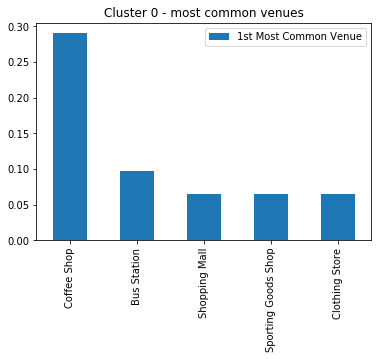

,1st Most Common Venue
Coffee Shop,0.290323
Bus Station,0.096774
Shopping Mall,0.064516
Sporting Goods Shop,0.064516
Clothing Store,0.064516


In [265]:
## Cluster 0 - busy places. Lots of people. Good for fast food/snacks.

cluster=0

most_common(cluster).plot.bar()
plt.title('Cluster 0 - most common venues') 
plt.show()

most_common(cluster)

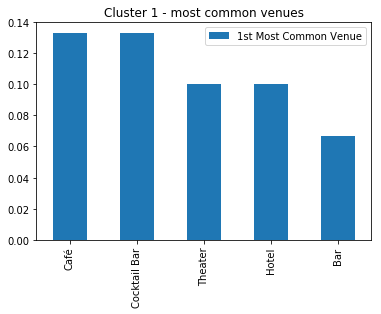

,1st Most Common Venue
Café,0.133333
Cocktail Bar,0.133333
Theater,0.100000
Hotel,0.100000
Bar,0.066667


In [264]:
## Cluster 1 - best for restaurant. Mainly in downtown, but not always...
cluster=1

most_common(cluster).plot.bar()
plt.title('Cluster 1 - most common venues') 
plt.show()

most_common(cluster)

In [244]:
cluster=2
most_common(cluster)

,1st Most Common Venue
Mountain,1.0


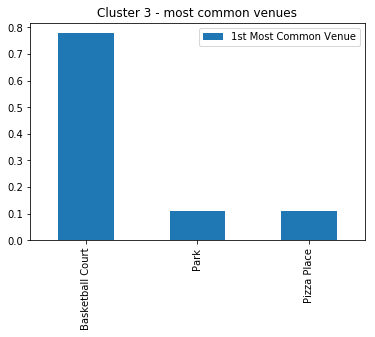

,1st Most Common Venue
Basketball Court,0.777778
Park,0.111111
Pizza Place,0.111111


In [266]:
## Cluster 3/4/5 - remote districts. Good for pizza/burger, rather than elegant restaurant/drink bar.
cluster=3
most_common(cluster).plot.bar()
plt.title('Cluster 3 - most common venues') 
plt.show()

most_common(cluster)

In [246]:
cluster=4
most_common(cluster)

,1st Most Common Venue
Burger Joint,1.0


In [247]:
cluster=5
most_common(cluster)

,1st Most Common Venue
Bus Station,0.857143
Supermarket,0.142857


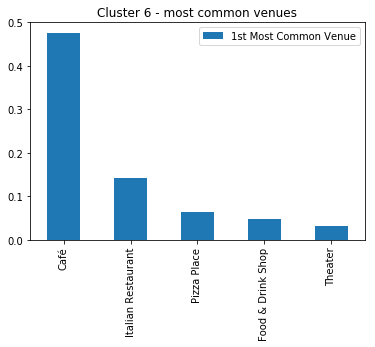

,1st Most Common Venue
Café,0.476190
Italian Restaurant,0.142857
Pizza Place,0.063492
Food & Drink Shop,0.047619
Theater,0.031746


In [268]:
## Cluster 6 - not in very city center, but good for sam cafe's, inexpensive food places.
cluster=6

most_common(cluster).plot.bar()
plt.title('Cluster 6 - most common venues') 
plt.show()

most_common(cluster)

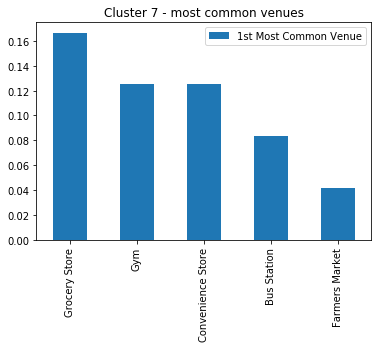

,1st Most Common Venue
Grocery Store,0.166667
Gym,0.125000
Convenience Store,0.125000
Bus Station,0.083333
Farmers Market,0.041667


In [269]:
cluster=7

most_common(cluster).plot.bar()
plt.title('Cluster 7 - most common venues') 
plt.show()

most_common(cluster)

In [252]:
## Cluster 8 and 9 - recreation areas.
cluster=8
most_common(cluster)

,1st Most Common Venue
Park,1.0


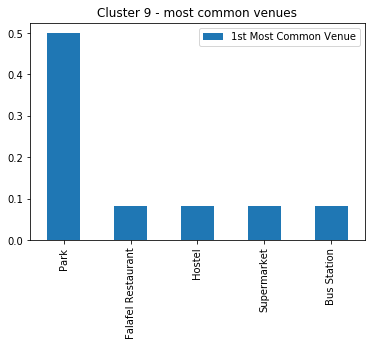

,1st Most Common Venue
Park,0.500000
Falafel Restaurant,0.083333
Hostel,0.083333
Supermarket,0.083333
Bus Station,0.083333


In [270]:
cluster=9

most_common(cluster).plot.bar()
plt.title('Cluster 9 - most common venues') 
plt.show()

most_common(cluster)

## Results - findings about clusters:

* Cluster 0 - busy places. Lots of people. Good for fastfood/snacks places like "Subway" or others "takeaway's".
* Cluster 1 - best for restaurant. Mainly in downtown, but not always.
* Cluster 2 - small one... Perhaps shoud be merged with some other cluster...
* Cluster 3/4/5 - remote districts. Good for pizza/burger, rather than elegant restaurant/drink bar.
* Cluster 6 - not in very city center, but good for sam cafe's, inexpensive food places. MIGHT BE BEST TO INVEST MONEY THERE!
* Cluster 7 - stores, gym, etc.
* Cluster 8 and 9 - recreation areas.

## Discussion section:

* Perhaps the most interesting cluster for investing money in food restauranst might by cluster no 6 - not in very city center (so not so pricy), but still with lot of gastro-venus and cafes
* But also as a global investor we may think about some cheap/fastfood chain in places like in cluster no 0 - buzy places with lot of people.
* And if we want to open some posh-pricey elegant place, cluster no 1 would be the best


## Conslusions:

### The analysis shows that clustering districts look reasonable (I know Warsaw), so we can conduct similar analysis for other cities all over the world without knowing them and in automatic manner find some similar clusters, profile them and take decisions as a investor.